In [7]:
# ============================================
# 📘 Loan Approval Prediction (Clean + Corrected)
# ============================================
# Problem: Build logistic regression model to predict
# if a new customer should be given a loan or not.
# ============================================

# ---------- 1. Import Libraries ----------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [8]:
# ---------- 2. Load Dataset ----------
df = pd.read_csv(r'C:\Users\oluwa\Downloads\loan_approval_dataset.csv')
print("Dataset Loaded Successfully")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n")
print(df.info())


Dataset Loaded Successfully
Shape: (4269, 13)

Columns: ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

Missing Values:
 loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

Data Types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4

In [9]:
# ---------- 3. Quick Look ----------
print("\nSample Records:")
print(df.head())

# ---------- 4. EDA Cleaning ----------
# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    .str.lower()
)

# Clean string values
string_cols = df.select_dtypes(include='object').columns
for col in string_cols:
    df[col] = df[col].astype(str).str.strip().str.replace('[^A-Za-z0-9 ]+', '', regex=True)



Sample Records:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \
0        

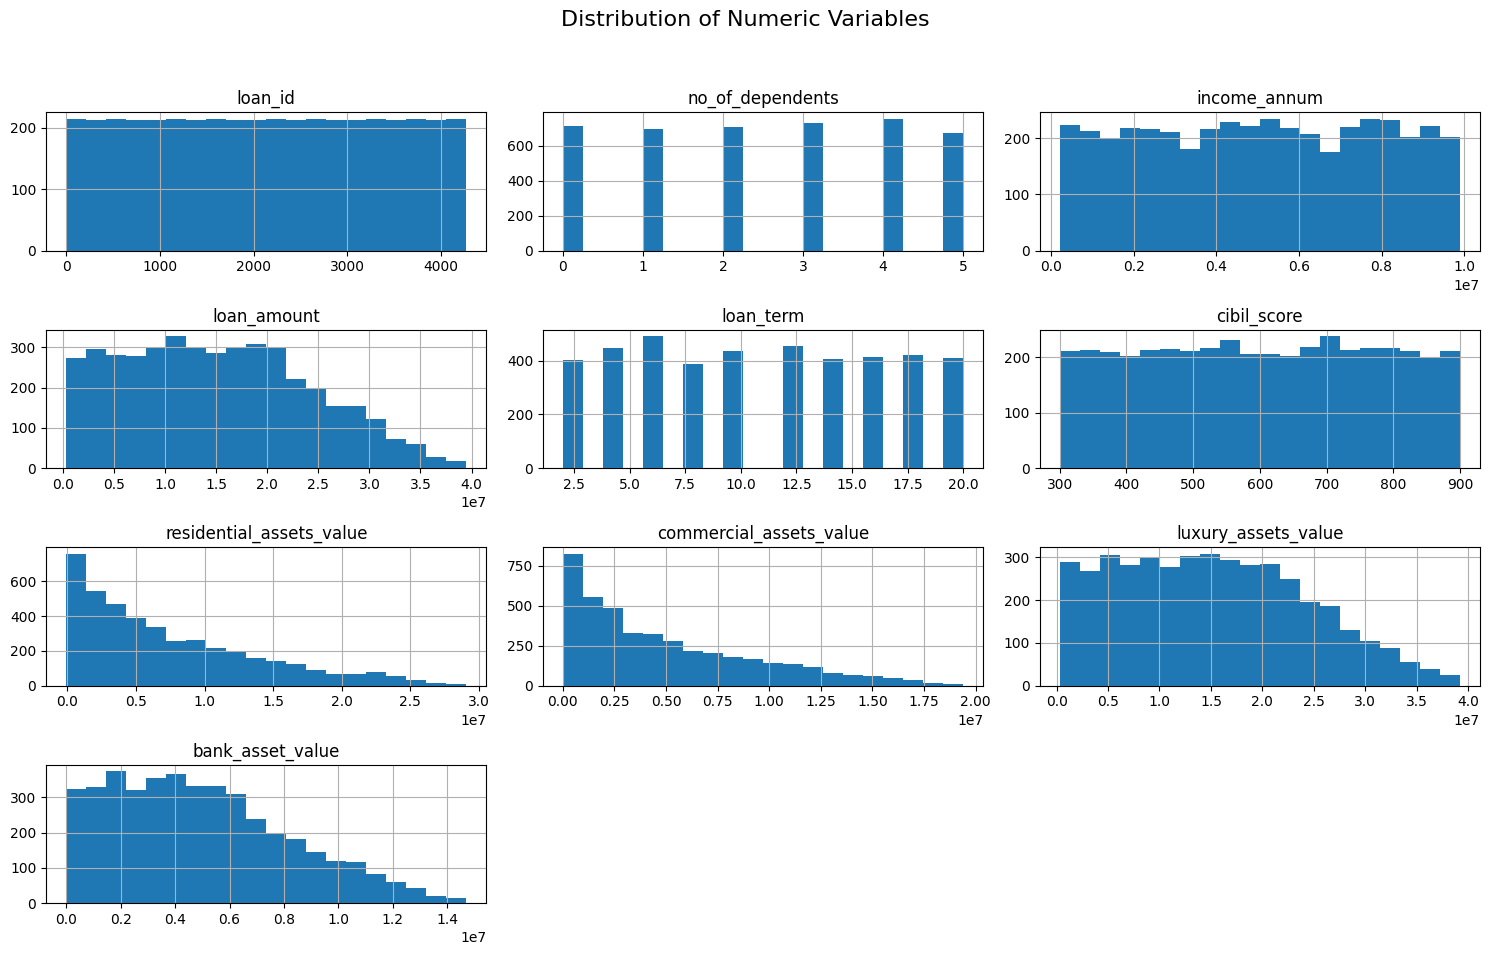

In [10]:
# ==========================
# Distribution of Numeric Variables
# ==========================
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


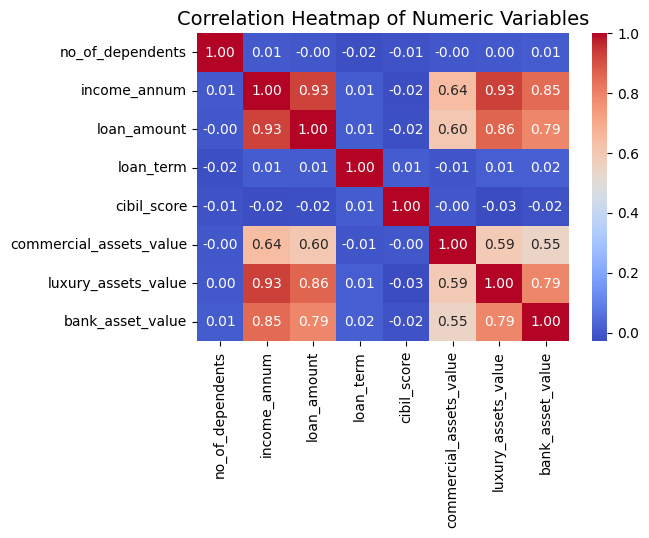

In [15]:
# ==========================
# Correlation Heatmap
# ==========================
plt.figure(figsize=(6, 4))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Variables", fontsize=14)
plt.show()

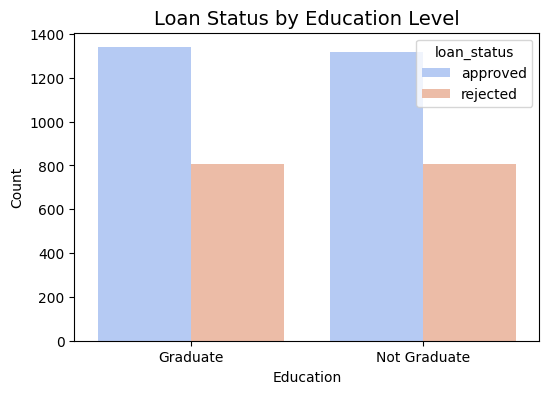

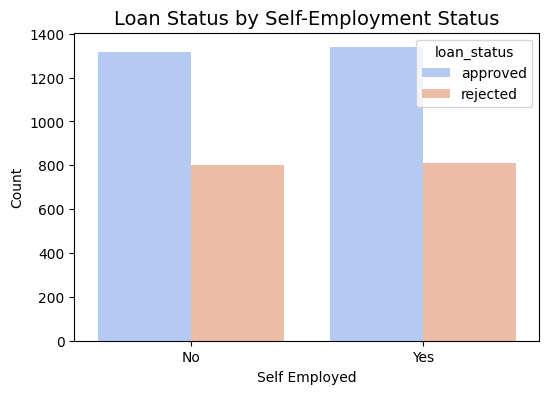

In [17]:
# ==========================
# Loan Approval Patterns
# ==========================
if "education" in df.columns and "loan_status" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x="education", hue="loan_status", palette="coolwarm")
    plt.title("Loan Status by Education Level", fontsize=14)
    plt.xlabel("Education")
    plt.ylabel("Count")
    plt.show()

if "self_employed" in df.columns and "loan_status" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x="self_employed", hue="loan_status", palette="coolwarm")
    plt.title("Loan Status by Self-Employment Status", fontsize=14)
    plt.xlabel("Self Employed")
    plt.ylabel("Count")
    plt.show()

In [13]:
# ==========================
# Key Insights Summary
# ==========================
if "loan_status" in df.columns:
    loan_status_summary = df["loan_status"].value_counts(normalize=True) * 100
    print("\n===== Loan Status Distribution =====")
    print(loan_status_summary.round(2))

if "education" in df.columns and "loan_status" in df.columns:
    education_status = pd.crosstab(df["education"], df["loan_status"], normalize="index") * 100
    print("\n===== Loan Status by Education =====")
    print(education_status.round(2))

if "self_employed" in df.columns and "loan_status" in df.columns:
    employment_status = pd.crosstab(df["self_employed"], df["loan_status"], normalize="index") * 100
    print("\n===== Loan Status by Self-Employment =====")
    print(employment_status.round(2))


===== Loan Status Distribution =====
loan_status
Approved    62.22
Rejected    37.78
Name: proportion, dtype: float64

===== Loan Status by Education =====
loan_status   Approved  Rejected
education                       
Graduate         62.45     37.55
Not Graduate     61.98     38.02

===== Loan Status by Self-Employment =====
loan_status    Approved  Rejected
self_employed                    
No                62.20     37.80
Yes               62.23     37.77



Numeric columns: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical columns: ['education', 'self_employed']

Target distribution:
 loan_status_binary
1    0.622
0    0.378
Name: proportion, dtype: float64

CV Accuracy: 0.9180 ± 0.0162
CV ROC AUC: 0.9664 ± 0.0082

===== Test Performance =====
Accuracy: 0.9239
Precision: 0.9551
Recall: 0.9209
F1 Score: 0.9377
ROC AUC: 0.9734

Classification Report:
              precision    recall  f1-score   support

           0     0.8772    0.9288    0.9023       323
           1     0.9551    0.9209    0.9377       531

    accuracy                         0.9239       854
   macro avg     0.9161    0.9248    0.9200       854
weighted avg     0.9256    0.9239    0.9243       854



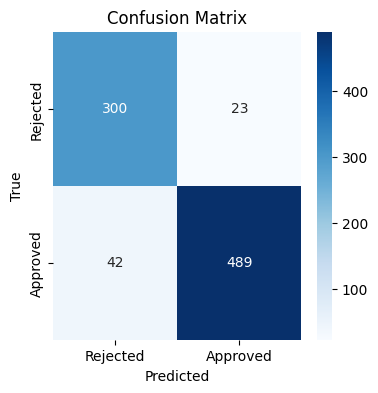

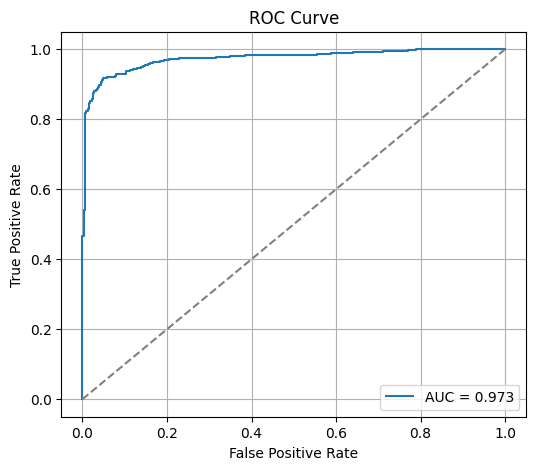


===== Top 10 Most Influential Features =====
                  feature  coefficient  abs_coef
0             cibil_score     4.228211  4.228211
1            income_annum    -1.480854  1.480854
2             loan_amount     1.238355  1.238355
3               loan_term    -0.783198  0.783198
4      education_Graduate     0.390096  0.390096
5       self_employed_Yes     0.336227  0.336227
6        self_employed_No     0.319772  0.319772
7  education_Not Graduate     0.265903  0.265903
8        bank_asset_value     0.174677  0.174677
9     luxury_assets_value     0.128979  0.128979


In [14]:
# ==========================
# Modeling
# ==========================
# Target cleaning
df['loan_status'] = df['loan_status'].str.strip().str.lower()
df['loan_status'] = df['loan_status'].replace({
    'approved': 'approved', 'approve': 'approved', 'yes': 'approved',
    'rejected': 'rejected', 'reject': 'rejected', 'no': 'rejected'
})
df['loan_status_binary'] = df['loan_status'].map({'approved': 1, 'rejected': 0})
df = df.dropna(subset=['loan_status_binary'])

# Drop ID-like column
for col in df.columns:
    if 'id' in col.lower():
        df = df.drop(columns=[col])

# Identify types
for col in df.columns:
    if col not in ['loan_status', 'loan_status_binary']:
        df[col] = pd.to_numeric(df[col], errors='ignore')

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'loan_status_binary' in numeric_cols:
    numeric_cols.remove('loan_status_binary')

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'loan_status' in categorical_cols:
    categorical_cols.remove('loan_status')

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("\nTarget distribution:\n", df['loan_status_binary'].value_counts(normalize=True).round(3))

# Split
X = df.drop(columns=['loan_status', 'loan_status_binary'])
y = df['loan_status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Model pipeline
logreg = LogisticRegression(solver='liblinear', class_weight='balanced',
                            random_state=42, max_iter=1000)
pipeline = Pipeline([('preprocessor', preprocessor), ('clf', logreg)])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
roc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"\nCV Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"CV ROC AUC: {roc_scores.mean():.4f} ± {roc_scores.std():.4f}")

# Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n===== Test Performance =====")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance (Top 10)
feature_names = numeric_cols.copy()
if categorical_cols:
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names.extend(cat_names)

coefs = pipeline.named_steps['clf'].coef_.flatten()
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)

print("\n===== Top 10 Most Influential Features =====")
print(coef_df.head(10))